In [1]:
# --- Core Data Handling ---
import pandas as pd
# Pandas is used for loading the dataset (CSV/Excel/etc.) and for
# managing tabular data as DataFrames, which is convenient for
# cleaning, transforming, and passing to the mlxtend functions.

# --- Pre-processing for Market Basket Data ---
from mlxtend.preprocessing import TransactionEncoder
# TransactionEncoder converts a list of transactions (lists of items)
# into a one-hot encoded DataFrame (rows = transactions,
# columns = items, True/False for presence) so that
# frequent-pattern algorithms can process it.

# --- Frequent Pattern Mining ---
from mlxtend.frequent_patterns import fpgrowth, association_rules
# fpgrowth: implements the FP-Growth algorithm to efficiently find
# frequent itemsets (groups of items that often appear together).
# association_rules: takes the frequent itemsets and generates
# association rules (with metrics like support, confidence, lift).

# --- Visualization ---
import networkx as nx
# NetworkX allows you to build a graph where each node is an item
# and edges represent association rules. Great for visualizing
# item relationships as a network.

import matplotlib.pyplot as plt
# Matplotlib provides plotting capabilities. Here it is used with
# NetworkX to draw the association rule graph and possibly other
# charts such as support vs. confidence plots.


In [2]:
file_path = "Dataset.csv"     # Path to your dataset CSV file (update if needed)

# Read CSV with no header row; each row = one transaction with items in columns
raw = pd.read_csv(file_path, header=None)

# Convert each row into a clean list of items:
# - dropna() removes empty cells
# - str(item).strip() ensures each item is a trimmed string
transactions = raw.apply(
    lambda row: [str(item).strip() for item in row.dropna()],
    axis=1
).tolist()

# Display number of transactions and first 3 for a quick check
print(f"Loaded {len(transactions)} transactions, example:\n", transactions[0:3])


Loaded 7501 transactions, example:
 [['shrimp', 'almonds', 'avocado', 'vegetables mix', 'green grapes', 'whole weat flour', 'yams', 'cottage cheese', 'energy drink', 'tomato juice', 'low fat yogurt', 'green tea', 'honey', 'salad', 'mineral water', 'salmon', 'antioxydant juice', 'frozen smoothie', 'spinach', 'olive oil'], ['burgers', 'meatballs', 'eggs'], ['chutney']]


In [3]:
# Initialize the TransactionEncoder to convert lists of items into a one-hot encoded matrix
te = TransactionEncoder()

# Fit the encoder on all items and transform the transaction list into a sparse matrix
te_array = te.fit(transactions).transform(transactions, sparse=True)

# Convert the sparse matrix to a pandas DataFrame with sparse boolean columns
basket_df = pd.DataFrame.sparse.from_spmatrix(
    te_array, columns=te.columns_
).astype(bool)   # ensure each cell is True/False

# Print the shape: rows = transactions, columns = unique items
print("Encoded matrix shape:", basket_df.shape)


Encoded matrix shape: (7501, 119)


C:\Users\aditi\AppData\Local\Temp\ipykernel_28904\1205979604.py:8: FutureWarning: Allowing arbitrary scalar fill_value in SparseDtype is deprecated. In a future version, the fill_value must be a valid value for the SparseDtype.subtype.
  basket_df = pd.DataFrame.sparse.from_spmatrix(


In [4]:
# Find frequent itemsets using the FP-Growth algorithm
# min_support=0.01 → itemsets must appear in at least 1% of transactions
# use_colnames=True → show item names instead of column indices
itemsets = fpgrowth(basket_df, min_support=0.01, use_colnames=True)

# Sort the itemsets in descending order of support (most frequent first)
itemsets = itemsets.sort_values("support", ascending=False)

# Display the top few frequent itemsets with their support values
print("Top frequent itemsets:\n", itemsets.head())


Top frequent itemsets:
      support         itemsets
0   0.238368  (mineral water)
15  0.179709           (eggs)
26  0.174110      (spaghetti)
22  0.170911   (french fries)
31  0.163845      (chocolate)


In [5]:
# Generate association rules from the frequent itemsets
# metric="confidence", min_threshold=0.3 → only keep rules with confidence ≥ 30%
rules = association_rules(itemsets, metric="confidence", min_threshold=0.3)

# Sort rules so the strongest (highest lift and confidence) appear first
rules = rules.sort_values(["lift", "confidence"], ascending=False)

# Show a quick preview of the top association rules
print("Sample rules:\n", rules.head())


Sample rules:
                            antecedents    consequents  antecedent support  \
29                     (herb & pepper)  (ground beef)            0.049460   
25        (ground beef, mineral water)    (spaghetti)            0.040928   
50  (frozen vegetables, mineral water)         (milk)            0.035729   
35                              (soup)         (milk)            0.050527   
4                        (ground beef)    (spaghetti)            0.098254   

    consequent support   support  confidence      lift  representativity  \
29            0.098254  0.015998    0.323450  3.291994               1.0   
25            0.174110  0.017064    0.416938  2.394681               1.0   
50            0.129583  0.011065    0.309701  2.389991               1.0   
35            0.129583  0.015198    0.300792  2.321232               1.0   
4             0.174110  0.039195    0.398915  2.291162               1.0   

    leverage  conviction  zhangs_metric   jaccard  certainty  kul

In [6]:
# Filter rules where the consequent (right-hand side) has only one item
single_conseq = rules[rules["consequents"].apply(lambda x: len(x) == 1)]

# Print how many such single-item consequent rules exist
print("Single-item consequent rules:", single_conseq.shape[0])


Single-item consequent rules: 63


In [7]:
# Save the generated association rules to a CSV file (without the index column)
rules.to_csv("association_rules.csv", index=False)

# Save the frequent itemsets to a separate CSV file
itemsets.to_csv("frequent_itemsets.csv", index=False)

# Confirm that both files were saved
print("Saved association_rules.csv and frequent_itemsets.csv")


Saved association_rules.csv and frequent_itemsets.csv


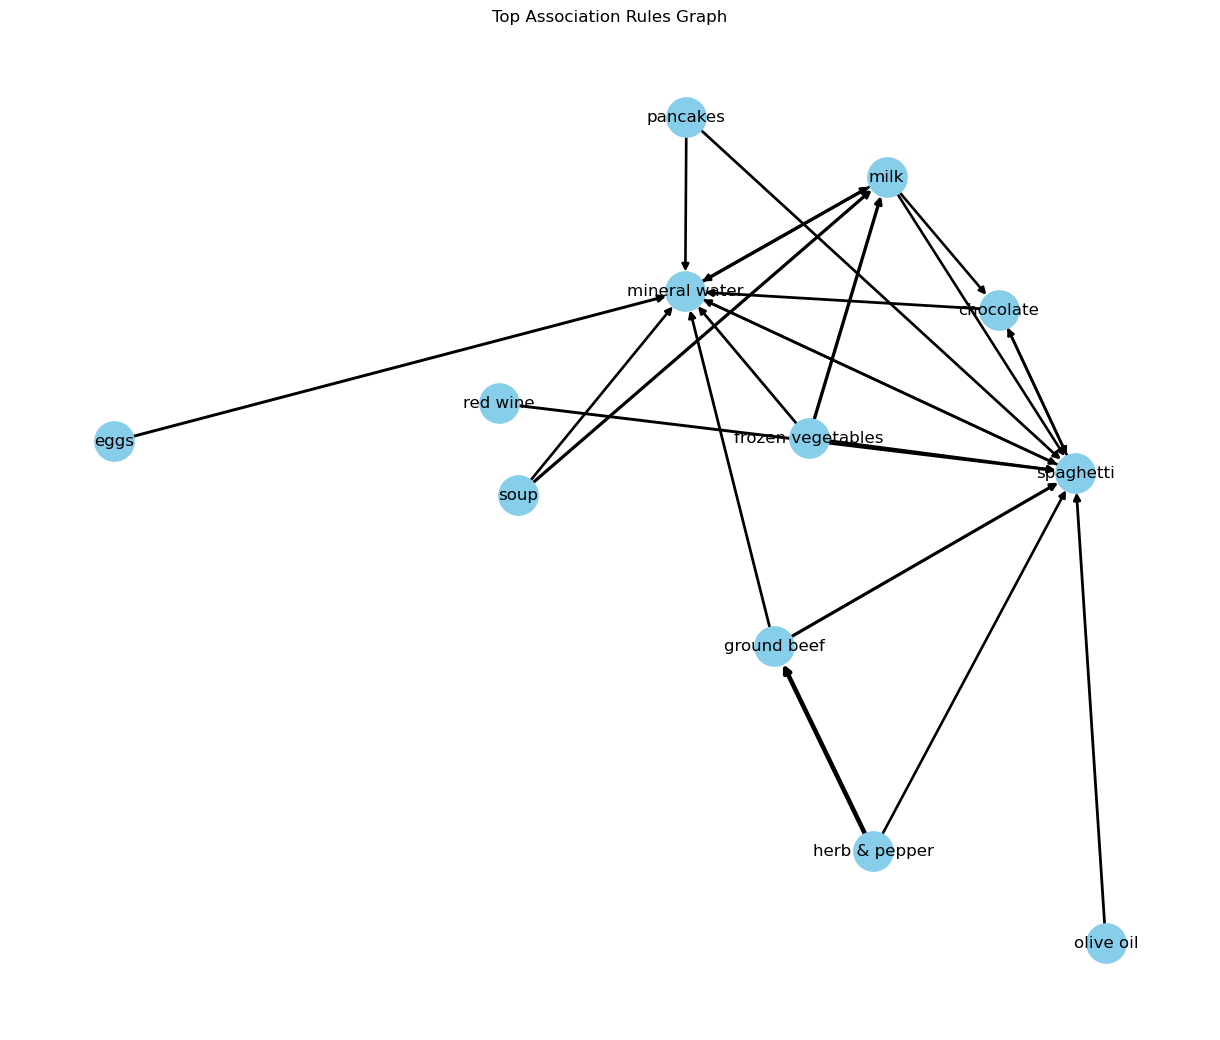

In [8]:
def plot_rule_graph(rules_df, top_n=20):
    """Visualize top association rules as a directed graph."""
    
    # Take only the top_n rules (sorted outside if needed)
    use = rules_df.head(top_n)
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add edges: each rule connects its antecedent(s) → consequent(s)
    for _, r in use.iterrows():
        for a in r['antecedents']:
            for c in r['consequents']:
                G.add_edge(a, c, weight=r['lift'])  # edge weight = lift value
    
    # Compute layout for node positioning
    pos = nx.spring_layout(G, k=0.8)
    
    # Plot the graph
    plt.figure(figsize=(12, 10))
    nx.draw(
        G, pos, with_labels=True,
        node_size=800, node_color="skyblue",
        width=[d['weight'] for _, _, d in G.edges(data=True)]
    )
    plt.title("Top Association Rules Graph")
    plt.show()

# Call the function on single-item consequent rules,
# sorted by highest lift for best visibility
plot_rule_graph(single_conseq.sort_values('lift', ascending=False))
